In [1]:
%%writefile requirements.txt

numpy==1.24.4
pandas==2.1.2
matplotlib==3.8.0
xgboost==2.1.3
scikit-learn==1.5.2

Overwriting requirements.txt


In [2]:
!pip install -r requirements.txt

In [3]:
import pandas as pd  # For data manipulation and analysis
import numpy as np  # For numerical computations
from xgboost import XGBClassifier  # For building the machine learning model
from collections import Counter  # For counting occurrences of elements
import matplotlib.pyplot as plt  # For visualizing results
from matplotlib.sankey import Sankey # For a flow diagram visualizing the pipeline
from sklearn.preprocessing import StandardScaler  # For feature scaling
from sklearn.utils.class_weight import compute_class_weight  # For handling class imbalance
import logging  # For debugging and logging simulation details
import os  # For file and directory operations
import itertools  # For creating combinations of matchups
from pathlib import Path
import time # For testing how long the simulations are taking to run
from sklearn.metrics import accuracy_score # Predict the accuracy of the test set
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix # Validation for Supervised Learning
from sklearn.model_selection import StratifiedKFold, cross_val_score # Validation for Gradient Boosting with XGBoost
from sklearn.inspection import permutation_importance # Validation for Feature Engineering

In [4]:
# For logging and Degugging
# Create output folder if it doesn't exist, for data outputs and checks during development
folder_path = "output"

# Check if the folder exists
folder_path = Path("output")

# Create the folder if it doesn't exist
folder_path.mkdir(parents=True, exist_ok=True)

print(f"Folder created: {folder_path}")

# Ensure debug log file is deleted
folder_path = "debugging"
log_file = "debugging/simulation_debug.log"

# Check if the folder exists
folder_path = Path("debugging")

# Create the folder if it doesn't exist
folder_path.mkdir(parents=True, exist_ok=True)

print(f"Folder created: {folder_path}")

if os.path.exists(log_file):  # Check if the log file exists
    os.remove(log_file)  # Delete the log file
    print(f"Deleted existing log file: {log_file}")
else:
    print(f"No log file to delete: {log_file}")

# Configure logging
logging.basicConfig(
    filename=log_file,  # Log file to store debug information
    level=logging.INFO,  # Log only error-level messages
    format="%(asctime)s - %(levelname)s - %(message)s"  # Format of log messages
)

Folder created: output
Folder created: debugging
Deleted existing log file: debugging/simulation_debug.log


In [5]:
# Helper function to save variable data to the output folder
def save_to_output(variable_name, data):
    output_file = f"output/{variable_name}.txt"
    if isinstance(data, pd.DataFrame):
        data.to_csv(output_file, index=False)
    elif isinstance(data, (list, dict, np.ndarray)):
        with open(output_file, "w") as f:
            f.write(str(data))
    else:
        with open(output_file, "w") as f:
            f.write(str(data))
    print(f"Saved {variable_name} to {output_file}")

In [6]:
# Load the Data
data_path = "dataSets/cbbAll.csv"
data = pd.read_csv(data_path)

# Map POSTSEASON to Numerical Values
postseason_mapping = {
    "R64": 0,
    "R32": 1,
    "S16": 2,
    "E8": 3,
    "F4": 4,
    "2ND": 5,
    "Champions": 6
}
data['POSTSEASON'] = data['POSTSEASON'].map(postseason_mapping)

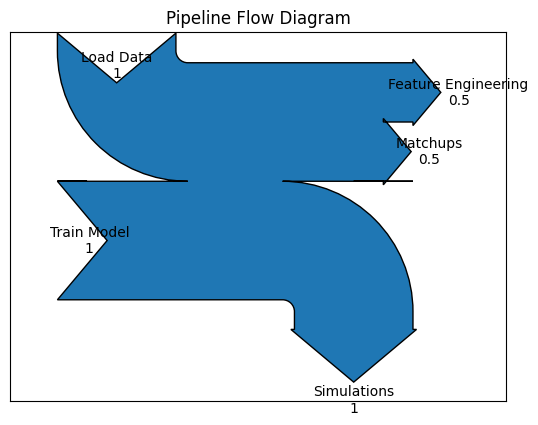

In [7]:
# Flow Diagram: Visualizing the Pipeline
Sankey(flows=[1, -0.5, -0.5, 1, -1],  
       labels=['Load Data', 'Feature Engineering', 'Matchups', 'Train Model', 'Simulations'],
       orientations=[1, 0, 0, 0, -1]).finish()

plt.title('Pipeline Flow Diagram')
plt.show()


In [8]:
# Calculate historical success for each team
data['HISTORICAL_SUCCESS'] = data.groupby('TEAM')['POSTSEASON'].transform('mean')

In [9]:
# Calculate Strength of Schedule
def calculate_strength_of_schedule(data):
    conf_means = data.groupby(['CONF'])[['ADJOE', 'ADJDE']].mean()
    data = data.merge(conf_means, on='CONF', suffixes=('', '_CONF_AVG'))
    data['SOS_ADJOE'] = data['ADJOE'] - data['ADJOE_CONF_AVG']
    data['SOS_ADJDE'] = data['ADJDE'] - data['ADJDE_CONF_AVG']
    return data

# Calculate Momentum
def calculate_momentum(data):
    data['MOMENTUM'] = data['W'] / data['G']
    return data

# Apply Feature Engineering
data = calculate_strength_of_schedule(data)
data = calculate_momentum(data)

# Calculate Rank
data = data.sort_values(by=['YEAR', 'POSTSEASON', 'SEED'], ascending=[True, False, True])
data['RANK'] = data.groupby('YEAR').cumcount() + 1

In [10]:
def generate_matchups(data):
    """
    Generates all pairwise matchups for teams in the tournament for each year.
    Eliminates self-matchups (where Team1 == Team2).
    
    Parameters:
        data (pd.DataFrame): Input DataFrame with tournament data.
    
    Returns:
        pd.DataFrame: Generated matchups.
    """
    matchups = []
    
    for year in data['YEAR'].unique():
        # Filter data for the specific year
        year_data = data[data['YEAR'] == year]
        
        # Check for duplicate teams in the same year
        if year_data.duplicated(subset=['TEAM']).any():
            logging.warning(f"Duplicate teams found in year {year}. Removing duplicates.")
            year_data = year_data.drop_duplicates(subset=['TEAM'])
        
        # Generate pairwise matchups
        for team1, team2 in itertools.combinations(year_data.itertuples(), 2):
            if team1.TEAM == team2.TEAM:  # Skip self-matchups
                logging.warning(f"Skipping self-matchup for team: {team1.TEAM} in year {year}")
                continue
            
            matchups.append({
                'Year': year,
                'Team1': team1.TEAM,
                'Team2': team2.TEAM,
                'Seed_diff': team1.SEED - team2.SEED,
                'SOS_ADJOE_diff': team1.SOS_ADJOE - team2.SOS_ADJOE,
                'SOS_ADJDE_diff': team1.SOS_ADJDE - team2.SOS_ADJDE,
                'BARTHAG_diff': team1.BARTHAG - team2.BARTHAG,
                'MOMENTUM_diff': team1.MOMENTUM - team2.MOMENTUM,
                'Rank_diff': team1.RANK - team2.RANK,
                'HISTORICAL_SUCCESS_diff': 4 * (team1.HISTORICAL_SUCCESS - team2.HISTORICAL_SUCCESS),
                'Winner': 1 if team1.POSTSEASON > team2.POSTSEASON else 0
            })
    
    return pd.DataFrame(matchups)

In [11]:
# Keep only the teams that have post-season experience
valid_teams = data[
    (data['POSTSEASON'] >= 0) & (data['POSTSEASON'] <= 6) &  # Postseason range
    (data['SEED'] >= 1) & (data['SEED'] <= 16) &            # Seed range
    (data['RANK'] >= 1) & (data['RANK'] <= 64)              # Rank range
].copy()

In [12]:
# Generate Matchup Data
matchup_data = generate_matchups(valid_teams)

# Scale HISTORICAL_SUCCESS_diff to increase its importance
matchup_data['HISTORICAL_SUCCESS_diff'] *= 10

# Filter Matchups for Valid Teams
filtered_matchups = matchup_data[
    (matchup_data['Team1'].isin(data['TEAM'])) &
    (matchup_data['Team2'].isin(data['TEAM']))
]


In [13]:
# Prepare Data for Training
model_features = [
    'Seed_diff'
    , 'SOS_ADJOE_diff'
    , 'SOS_ADJDE_diff'
    , 'BARTHAG_diff'
    , 'MOMENTUM_diff'
    , 'Rank_diff'
    , 'HISTORICAL_SUCCESS_diff'
    ]
train_data = filtered_matchups[filtered_matchups['Year'] < 2024]
test_data = filtered_matchups[filtered_matchups['Year'] == 2024]

X_train = train_data[model_features]
y_train = train_data['Winner']
X_test = test_data[model_features]
y_test = test_data['Winner']

# Standardize Features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Train Model
class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
xgb_model = XGBClassifier(
    n_estimators=200
    , learning_rate=0.1
    , max_depth=5          # Reduce tree depth to focus on simpler, impactful features
    , colsample_bytree=0.8 # Use fewer features per tree
    , subsample=0.8        # Use a subset of data per tree
    , random_state=42      # Add randomness to the training for feature equalizization
    , scale_pos_weight=class_weights[0])
xgb_model.fit(X_train_scaled, y_train)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=5, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=200, n_jobs=None,
              num_parallel_tree=None, random_state=42, ...)

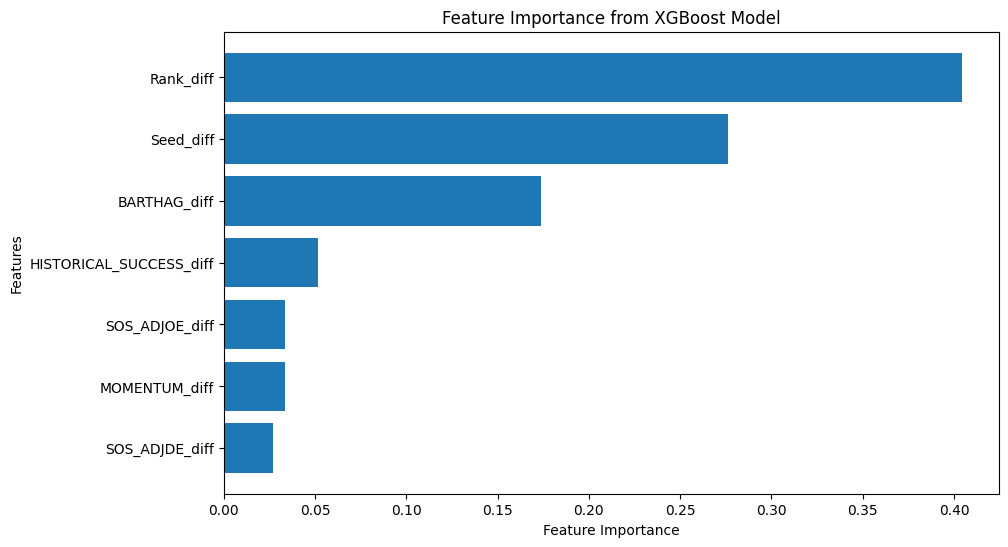

In [14]:
# Get feature importances from the model
# Visual
importances = xgb_model.feature_importances_
feature_names = model_features

# Sort features by importance
sorted_idx = np.argsort(importances)[::-1]
sorted_importances = importances[sorted_idx]
sorted_features = [feature_names[i] for i in sorted_idx]

# Plot feature importances
plt.figure(figsize=(10, 6))
plt.barh(sorted_features, sorted_importances, align='center')
plt.xlabel("Feature Importance")
plt.ylabel("Features")
plt.title("Feature Importance from XGBoost Model")
plt.gca().invert_yaxis()  # Invert y-axis for descending order
plt.show()

In [15]:
def simulate_bracket(matchups, model, rounds=6):
    """
    Simulates a tournament bracket and returns the champion.
    Eliminates self-matchups in all rounds.
    
    Parameters:
        matchups (pd.DataFrame): DataFrame of matchups with features for prediction.
        model (XGBClassifier): Trained model for predicting game outcomes.
        rounds (int): Number of tournament rounds to simulate.
    
    Returns:
        str: Champion team name, or None if no valid winner is determined.
    """
    current_round = matchups.copy()
    
    for round_num in range(1, rounds + 1):
        #logging.info(f"--- Starting Round {round_num} ---")
        winners = []
        
        for idx, game in current_round.iterrows():
            team1 = game['Team1']
            team2 = game['Team2']
            
            if team1 == team2:  # Skip self-matchups
                #logging.warning(f"Skipping self-matchup: {team1} vs {team2} in Round {round_num}")
                continue
            
            features = np.array([game[feature] for feature in model_features]).reshape(1, -1)
            prob_team1 = model.predict_proba(features)[0, 1]
            random_value = np.random.rand()
            winner = team1 if random_value < prob_team1 else team2
            
            # Log the matchup details
            '''
            logging.info(
                f"Round: {round_num}, Matchup: {team1} vs {team2}, "
                f"Seed_diff: {game['Seed_diff']}, SOS_ADJOE_diff: {game['SOS_ADJOE_diff']}, "
                f"SOS_ADJDE_diff: {game['SOS_ADJDE_diff']}, BARTHAG_diff: {game['BARTHAG_diff']}, "
                f"MOMENTUM_diff: {game['MOMENTUM_diff']}, Rank_diff: {game['Rank_diff']}, "
                f"prob_team1: {prob_team1:.4f}, random_value: {random_value:.4f}, Winner: {winner}"
            )
            '''
            winners.append(winner)
        
        # Ensure unique winners for the next round
        winners = list(set(winners))  # Remove duplicate winners
        
        if len(winners) % 2 != 0:
            #logging.warning(f"Odd number of winners in Round {round_num}. Removing last winner.")
            winners.pop()
        
        # Prepare matchups for the next round
        next_round = []
        for i in range(0, len(winners), 2):
            team1_row = current_round[(current_round['Team1'] == winners[i]) | (current_round['Team2'] == winners[i])].iloc[0]
            team2_row = current_round[(current_round['Team1'] == winners[i + 1]) | (current_round['Team2'] == winners[i + 1])].iloc[0]
            
            if winners[i] == winners[i + 1]:  # Ensure no self-matchups
                #logging.warning(f"Skipping self-matchup: {winners[i]} vs {winners[i]} in Round {round_num + 1}")
                continue
            
            next_round.append({
                'Team1': winners[i],
                'Team2': winners[i + 1],
                'Seed_diff': team1_row['Seed_diff'] - team2_row['Seed_diff'],
                'SOS_ADJOE_diff': team1_row['SOS_ADJOE_diff'] - team2_row['SOS_ADJOE_diff'],
                'SOS_ADJDE_diff': team1_row['SOS_ADJDE_diff'] - team2_row['SOS_ADJDE_diff'],
                'BARTHAG_diff': team1_row['BARTHAG_diff'] - team2_row['BARTHAG_diff'],
                'MOMENTUM_diff': team1_row['MOMENTUM_diff'] - team2_row['MOMENTUM_diff'],
                'Rank_diff': team1_row['Rank_diff'] - team2_row['Rank_diff'],
                'HISTORICAL_SUCCESS_diff': team1_row['HISTORICAL_SUCCESS_diff'] - team2_row['HISTORICAL_SUCCESS_diff']
            })
        
        current_round = pd.DataFrame(next_round)
        #logging.info(f"--- End of Round {round_num}. Winners: {winners} ---")
    
    # Determine champion
    champion = winners[0] if winners else None
    #logging.info(f"Champion: {champion}")
    
    #if champion is None:
        #logging.error("No valid winner determined in the final round.")
    
    return champion

Top 5 Most Frequent Champions:
Stony Brook: 5 wins
Penn St.: 2 wins
Iowa: 1 wins
Grand Canyon: 1 wins
Saint Mary's: 1 wins
Number of Unique Champions: 5
Unique Champions: {'Penn St.', "Saint Mary's", 'Grand Canyon', 'Stony Brook', 'Iowa'}


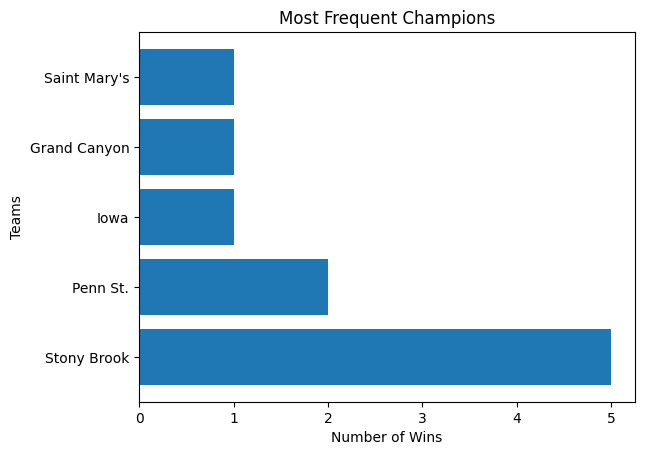

Script completed in  166.67 seconds.


In [16]:
############################################################################################################
####### Simulate multiple tournaments                                                                #######
####### Update num_simulations variable to change how many simulations are run and winners predicted #######
####### More simulations, more runtime                                                               #######
####### Test environment, Hyper-v WinServ 2022 Datacenter, host OS Win10 Pro i5, 32GB ram            #######
####### Tested up to 200 simulations, taking approx 11 minutes                                       #######
####### Time taken for 100 simulations: 714.23 seconds                                               #######
############################################################################################################
start_time = time.time()
num_simulations = 10  # Number of simulations to run
champions = [simulate_bracket(filtered_matchups, xgb_model) for _ in range(num_simulations)]  # Simulate and collect champions

# Analyze and visualize results
champion_counts = Counter(champions)  # Count occurrences of each champion
############################################################################################################
####### If running < 5 simulations, adjust the number of expected champions accordingly              #######
############################################################################################################
num_top_champions = 5  # Top N champions to display
print(f"Top {num_top_champions} Most Frequent Champions:")
for team, count in champion_counts.most_common(num_top_champions):  # Display top champions
    print(f"{team}: {count} wins")
unique_champions = set(champions)  # Unique champions
print(f"Number of Unique Champions: {len(unique_champions)}")
print(f"Unique Champions: {unique_champions}")
teams, counts = zip(*champion_counts.most_common(num_top_champions))  # Prepare for visualization
plt.barh(teams, counts)  # Create a horizontal bar chart
plt.title(f"Most Frequent Champions")
plt.xlabel("Number of Wins")
plt.ylabel("Teams")
plt.show()
end_time = time.time()
elapsed_time = end_time - start_time
print(f"Script completed in {elapsed_time: .2f} seconds.")

In [17]:
############################################################################################################
####### Begin Validations                                                                            #######
############################################################################################################

# Predict the test set
y_pred = xgb_model.predict(X_test_scaled)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Model Accuracy: {accuracy:.2f}")

Model Accuracy: 0.95


In [18]:
# Validation for Supervised learning
# Predict on test set
y_pred = xgb_model.predict(X_test_scaled)

# Calculate validation metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

# Confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Display results
print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1 Score: {f1:.2f}")
print("Confusion Matrix:")
print(conf_matrix)


Accuracy: 0.95
Precision: 0.99
Recall: 0.94
F1 Score: 0.97
Confusion Matrix:
[[ 641   10]
 [  82 1283]]


In [19]:
# Validation for Gradient Boosting with XGBoost
# Define cross-validation strategy
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Perform cross-validation
cv_scores = cross_val_score(xgb_model, X_train_scaled, y_train, cv=cv, scoring='accuracy')

# Display results
print(f"Cross-Validation Scores: {cv_scores}")
print(f"Mean CV Accuracy: {cv_scores.mean():.2f}")


Cross-Validation Scores: [0.96552579 0.96329365 0.96329365 0.9625496  0.96155754]
Mean CV Accuracy: 0.96


In [20]:
# Validation for Feature Engineering
# Compute permutation importance
perm_importance = permutation_importance(xgb_model, X_test_scaled, y_test, n_repeats=10, random_state=42)

# Display results
for i in perm_importance.importances_mean.argsort()[::-1]:
    print(f"Feature: {model_features[i]}, Importance: {perm_importance.importances_mean[i]:.4f}")


Feature: Rank_diff, Importance: 0.3641
Feature: Seed_diff, Importance: 0.1258
Feature: BARTHAG_diff, Importance: 0.0822
Feature: SOS_ADJDE_diff, Importance: 0.0159
Feature: HISTORICAL_SUCCESS_diff, Importance: 0.0098
Feature: MOMENTUM_diff, Importance: 0.0065
Feature: SOS_ADJOE_diff, Importance: 0.0055
